# 多GPU的简洁实现



In [1]:
import torch
from torch import nn
from d2l import torch as d2l

简单网络

In [3]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

net = resnet18(10)
devices = d2l.try_all_gpus()

训练

In [4]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

在单个GPU上训练网络

In [5]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

使用2个GPU进行训练

测试精度：0.80，8.5秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


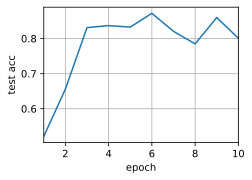

In [6]:
train(net, num_gpus=2, batch_size=512, lr=0.2)